# eBay 

The dataset, `ebay_ho2.parquet`, contains rows, each corresponding to a sold item on eBay under the *Best Offer* platform. 

The data comes from https://www.nber.org/research/data/best-offer-sequential-bargaining, from the paper “Sequential Bargaining in the Field: Evidence from Millions of Online Interactions” by Backus, Blake, Larsen & Tadelis (2020) in the Quarterly Journal of Economics. 

In [32]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.optimize import minimize

In [33]:
dat = pd.read_parquet('ebay_ho2.parquet')

In [34]:
dat.shape

(7903479, 22)

Variable labels in human readable form

In [35]:
var_labels = {'anon_item_id': 'Anonymized listing ID',
              'anon_leaf_categ_id': 'Anonymized leaf category ID, a finer categorization than meta categor',
              'fdbk_pstv_start':'sellers percent feedback score at the time of the listin',
              'start_price_usd': 'Buy-It-Now price', 'photo_count': 'Number of photos in listing', 
              'to_lst_cnt': 'Number of listings created by the seller dating back to 2008',
              'bo_lst_cnt': 'Number of BO-listings created by the seller dating back to 2008',
              'item_cndtn_id': 'Indicator for the new/used status of the item',
              'view_item_count': 'Number of times the item page was viewed',
              'wtchr_count': 'Number of users who selected the "add to watch list" option for this listing',              
              'anon_product_id': 'Anonymized product ID, only available for items that can be linked to specific cataloged products', 
              'count1': 'Number of listings used in creating ref_price1 for this observation',
              'ref_price1': 'Average price for sold fixed price listings with the same listing title as this item, sold during the time frame of the data',   
              'item_price': 'Final price (Buy-It-Now price if the item sold through Buy-It-Now option, or the final negotiated price if the item sold through Best Offer. ',
              'bo_ck_yn': 'Indicator for whether item sold through best offer.',
              'decline_price': 'Price chosen by seller, if the seller chooses to report one, below which any offer will be automatically rejected', 
              'accept_price': 'Price chosen by seller, if the seller chooses to report one, above which any offer will be automatically accepted', 
              'bin_rev': 'Indicator for whether the Buy-It-Now price was ever modified by the seller during the time the item was listed', 
              'lstg_gen_type_id': 'Indicator for whether the item is a re-listing (i.e. an item that failed to sell before and was then re-listed by the seller)', 
              'store': 'Indicator for whether the listing is part of an eBay store',
              'slr_us': 'Indicator for whether seller is located in US or not', 
              'buyer_us': 'Indicator for whether buyer is located in US or not', 
              'metacat': 'Product category (broad)', 
              'item_condition': 'Indicator for the new/used status of the item (categorical).', 
              'price2ref': 'Price relative to avg. among identical products (ref_price1)', 
              'price2start': 'Price relative to starting price (start_price_usd)'
             }

In [36]:
for v in dat.columns: 
    print(f'{v:<20}: {var_labels[v]}')

anon_product_id     : Anonymized product ID, only available for items that can be linked to specific cataloged products
anon_leaf_categ_id  : Anonymized leaf category ID, a finer categorization than meta categor
fdbk_pstv_start     : sellers percent feedback score at the time of the listin
start_price_usd     : Buy-It-Now price
photo_count         : Number of photos in listing
to_lst_cnt          : Number of listings created by the seller dating back to 2008
bo_lst_cnt          : Number of BO-listings created by the seller dating back to 2008
count1              : Number of listings used in creating ref_price1 for this observation
ref_price1          : Average price for sold fixed price listings with the same listing title as this item, sold during the time frame of the data
view_item_count     : Number of times the item page was viewed
wtchr_count         : Number of users who selected the "add to watch list" option for this listing
item_price          : Final price (Buy-It-Now price 

# Create variables

In [37]:
dat['price2ref']   = dat['item_price'] / dat['ref_price1']
dat['price2start'] = dat['item_price'] / dat['start_price_usd']

In [38]:
price_vars = ['item_price', 'price2ref', 'price2start']

In [39]:
price_labs = {'price2ref':'Price rel. to avg. for product', 'price2start':'Price rel. to starting price', 
              'item_price':'Price (USD)'}

# A few descriptives, just for curiosity

## Number of sales per category

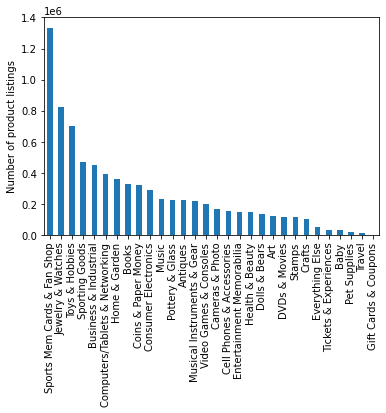

In [40]:
ax=dat.metacat.value_counts().plot(kind='bar'); 
ax.set_ylabel('Number of product listings'); 

## Price distributions

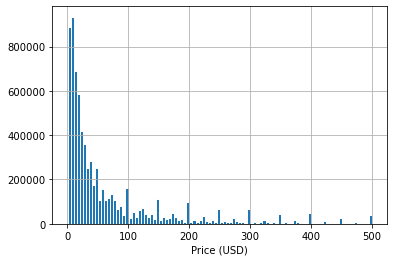

In [41]:
I = dat.item_price <= 500 # just to remove a few outliers 
ax = dat.loc[I].item_price.hist(bins=100,edgecolor='white'); 
ax.set_xlabel(price_labs['item_price']); 

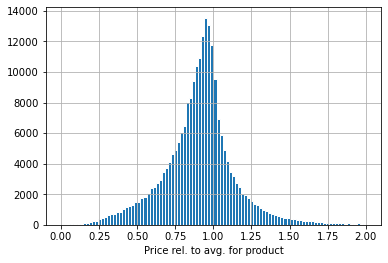

In [42]:
I = (dat.price2ref <= 2.0) & (dat.count1 >= 10) # if count1<10, then the reference price gets very noisy
ax = dat.loc[I].price2ref.hist(bins=100,edgecolor='white'); 
ax.set_xlabel(price_labs['price2ref']); 

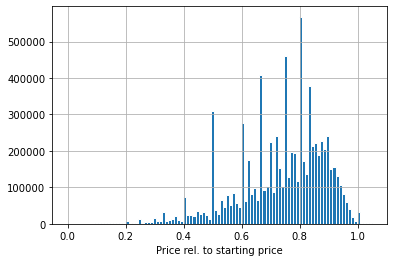

In [43]:
I = (dat.price2start <= 1.05) 
ax = dat.loc[I].price2start.hist(bins=100,edgecolor='white'); 
ax.set_xlabel(price_labs['price2start']); 

# Compare prices for two specific categories

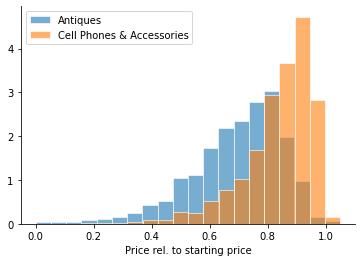

In [44]:
cats = ['Antiques',  'Cell Phones & Accessories']

fig,ax = plt.subplots(); 
for cat in cats: 
    I = (dat['price2start'] < 1.05) & (dat.metacat == cat)
    ax.hist(dat.loc[I, 'price2start'], bins=20, label=cat, alpha=0.6, density=True, edgecolor='white')

ax.legend(loc='best'); ax.set_xlabel(price_labs['price2start']); sns.despine();     

# Part A: Uniform valuations

This section focuses on the variable `price2start`, which is neatly distributed between 0 and 1, motivating us to focus on the uniform distribution. 

In [45]:
d = dat.groupby('metacat')[['price2start', 'view_item_count']].mean()
d

,price2start,view_item_count
metacat,,
Antiques,0.697898,45.201430
Art,0.678380,33.178491
Baby,0.759839,38.750195
Books,0.697726,19.118065
Business & Industrial,0.720395,36.085501
Cameras & Photo,0.795037,52.978987
Cell Phones & Accessories,0.842814,64.304693
Coins & Paper Money,0.794811,31.213884
Computers/Tablets & Networking,0.796257,45.466562


... continue on your own from here... write a function that takes `d.view_item_count` as an input and returns a predicted price. The data price that this should be compared to is `d.price2start`. 

# Part B: Non-uniformly Distributed Valuations

Now, we instead focus on the price variable, `price2ref`. 

In [46]:
price_var = 'price2ref'

## Subset the dataset

In [47]:
I = (dat.metacat == 'Cell Phones & Accessories') & (dat.price2ref < 2.0) & (dat.count1 >= 10)
d = dat[I].copy() # to avoid having a pointer 

Showing the overall distribution of that price

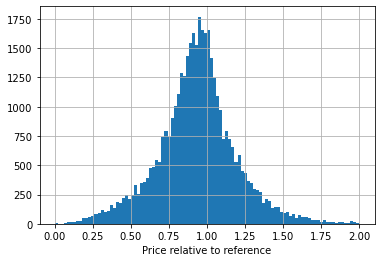

In [48]:
d[price_var].hist(bins=100); 
plt.xlabel('Price relative to reference'); 

## Question B.1

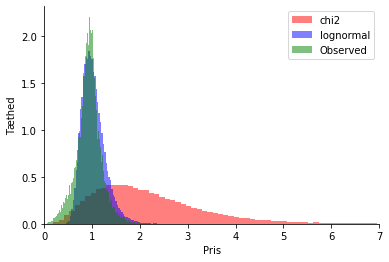

In [51]:
import matplotlib.pyplot as plt

n = 10
R = 100000

# chi square distributed valuations
v = np.random.chisquare(1, size=(n, R))

# find the second highest bid for each auction, r=1,...,R
# save an R-vector with the winning payments
win_chi2 = np.partition(v, -2, axis=0)[-2]

# log normal draws
w = np.exp(np.random.normal(-0.5, 0.5, size=(n, R)))

# find the second highest bid for each auction
win_lognorm = np.partition(w, -2, axis=0)[-2]

fig, ax = plt.subplots()
ax.hist(win_chi2, alpha=0.5, density=True, bins=100, label='chi2', color='red')
ax.hist(win_lognorm, alpha=0.5, density=True, bins=100, label='lognormal', color='blue')
ax.hist(d['price2ref'], alpha=0.5, density=True, bins=100, label='Observed', color='green')

ax.legend(loc='best')
sns.despine()

ax.set_xlim(0, 7)

ax.set_xlabel('Pris')
ax.set_ylabel('Tæthed')

plt.show()

## Question B.2

Find the $\mu$ that best fits the data. Two approaches: 
1. Just evaluate histograms for different values of $\mu$ and search "with your eye" *(minimum acceptable solution)* 
2. Minimize the "distance" between the simulated and real data. See the attached notebook, `ecdf.ipynb` for help. 

L2 criterion for these values =  0.004


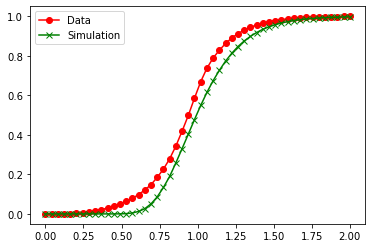

In [52]:
# 1. set up the grid on which we will be evaluating the ECDF functions
plow = 0.0
phigh = 2.0
xx = np.linspace(plow, phigh, 50)

# 2. construct the empirical CDF function handles
# ECDF returns a *function* which you can then evaluate at a vector of points 
ecdf_dat = ECDF(d['price2ref']) # the CDF function for the data 
ecdf_sim = ECDF(win_lognorm) # the variable from question B.1

# 3. show a plot together 
# we evaluate the two cdf functions on the same grid
plt.plot(xx, ecdf_dat(xx), '-o', color='red', label='Data')
plt.plot(xx, ecdf_sim(xx), '-x', color='green', label='Simulation'); 
plt.legend(); 

# 4. compute the L2 distance between the two CDF functions
# (see ecdf.ipynb for help with this)
L2 = np.mean((ecdf_dat(xx) - ecdf_sim(xx))**2)
print(f'L2 criterion for these values = {L2:6.3f}')


The best fit µ is -0.575


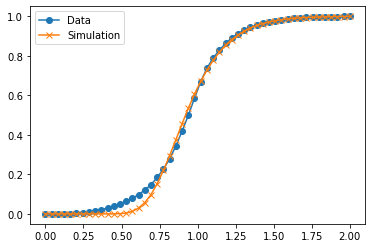

In [68]:
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF

def simulate_lognorm(mu, N=10, R=100000):
    return np.sort(np.exp(np.random.normal(mu, 0.5, (N, R))), axis=0)[N-2, :]

def L2(mu, data, xx):
    win_lognorm = simulate_lognorm(mu)
    ecdf_sim = ECDF(win_lognorm)
    ecdf_dat = ECDF(data)
    return np.mean((ecdf_dat(xx) - ecdf_sim(xx))**2)

data = d['price2ref']
plow = 0.0
phigh = 2.0
xx = np.linspace(plow, phigh, 50)

# Optimize
result = optimize.minimize_scalar(L2, args=(data, xx))
mu_opt = result.x

print(f'The best fit µ is {mu_opt:.3f}')

win_lognorm_opt = simulate_lognorm(mu_opt)

ecdf_dat = ECDF(data)
ecdf_sim_opt = ECDF(win_lognorm_opt)

plt.plot(xx, ecdf_dat(xx), '-o', label='Data')
plt.plot(xx, ecdf_sim_opt(xx), '-x', label='Simulation')
plt.legend()
plt.show()

# 3.B.3

In [82]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 
from scipy import stats
import seaborn as sns
from scipy import interpolate 

In [83]:
def Ev_largest(vi, v_sim_untruncated, N, R_used_min=42): 
    '''Ev_largest: compute the expected value of maximum drawing from a truncated distribtion 
                    where v_sim_untruncated are draws from the untruncated and vi is the 
                    truncation point. 
        
        INPUTS: 
            vi: (scalar) upper truncation point 
            v_sim_untruncated: (R-length 1-dim np array) draws of v from the untruncated distribution
            N: (int) number of draws per iteration  
            R_used_min: (int, optional) assert that we have at least this many samples. (Set =0 to disable.)
            
        OUTPUTS
            Ev: (float) expected value of the largest across simulations
            R_used: (int) no. replications used to compute simulated expectation
    '''
    assert v_sim_untruncated.ndim == 1, f'Expected 1-dimensional array'
    
    # perform truncation 
    I = v_sim_untruncated <= vi
    v_sim = np.copy(v_sim_untruncated[I])

    # drop extra rows
    drop_this_many = np.mod(v_sim.size, N)
    if drop_this_many>0: 
        v_sim = v_sim[:-drop_this_many]
    
    # reshape
    R_used = int(v_sim.size / N)
    v_sim = np.reshape(v_sim, (N,R_used))
    assert R_used > R_used_min, f'Too few replications included: only {R_used}. Try increasing original R.'
    
    # find largest value 
    v_sim = np.sort(v_sim, 0) # sorts ascending ... 
    v_largest = v_sim[-1, :]  # ... so the last *row* is the maximum in columns (samples)
    
    # evaluate expectation
    Ev = np.mean(v_largest)
    
    return Ev

# 3.B.4

FPSB: Gns. betaling = 0.8182, Std. afvigelse = 0.07, Median = 0.8396
SPSB: Gns. betaling = 0.8179, Std. afvigelse = 0.11, Median = 0.8377


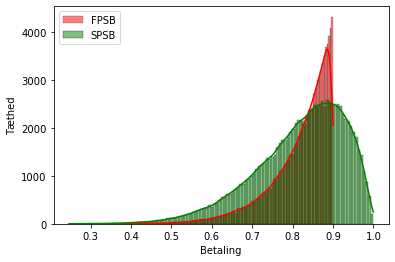

In [23]:
# Sæt random seed for reproducerbarhed
np.random.seed(1337)

# Definer antallet af budgivere og simuleringer
N = 10
R = 100000

# Definer fordelingen af valueringer
v = np.random.uniform(0, 1, (N, R))

# Definer den optimale budfunktion for FPSB
b_star = lambda vi, N: (N-1)/N * vi

# Beregn de optimale bud for FPSB
b = b_star(v, N)

# Omform arrays til sortering og indeksering
v = v.reshape((N, R))
b = b.reshape((N, R))

# Sorter valueringer og bud
idx = np.argsort(v, axis=0)
v = np.take_along_axis(v, idx, axis=0)
b = np.take_along_axis(b, idx, axis=0)

# Find den vindende spiller og deres betaling i FPSB
vindende_spiller = N
betaling_fpsb = b[-1, :]

# Find den næsthøjeste valuering for SPSB
næsthøjeste_valuering = v[-2, :]

# Simulér betalinger i SPSB
betaling_spsb = næsthøjeste_valuering

# Udskriv og plot resultaterne
fig, ax = plt.subplots()

# Beregn og vis gennemsnit, standardafvigelse og median for betalinger
gns_betaling_fpsb = np.mean(betaling_fpsb)
std_afvigelse_fpsb = np.sqrt(np.var(betaling_fpsb))
median_fpsb = np.median(betaling_fpsb)
print(f"FPSB: Gns. betaling = {gns_betaling_fpsb:.4f}, Std. afvigelse = {std_afvigelse_fpsb:.2f}, Median = {median_fpsb:.4f}")

gns_betaling_spsb = np.mean(betaling_spsb)
std_afvigelse_spsb = np.sqrt(np.var(betaling_spsb))
median_spsb = np.median(betaling_spsb)
print(f"SPSB: Gns. betaling = {gns_betaling_spsb:.4f}, Std. afvigelse = {std_afvigelse_spsb:.2f}, Median = {median_spsb:.4f}")

# Plots histogrammer over betalinger
sns.histplot(betaling_fpsb, ax=ax, label='FPSB', kde=True, color='red', alpha=0.5)
sns.histplot(betaling_spsb, ax=ax, label='SPSB', kde=True, color='green', alpha=0.5)

# Tilpas plottet
ax.set_xlabel('Betaling')
ax.set_ylabel('Tæthed')
ax.legend()

plt.show()

# Denne kode har taget udgangspunkt i koden fra revenue_equivalence.ipynb fra GitHub-repositoriet til kurset.

# 3.A.2

In [24]:
d = dat.groupby('metacat')[['price2start', 'view_item_count']].mean()

x = 0.20  # Andelen af besøgende, der deltager i auktionen

# Beregn de forventede betalinger for hver kategori
d['expected_payment'] = (x * d['view_item_count'] - 1) / (x * d['view_item_count'] + 1)

# Udskriv resultaterne
print(d)

# Print resultaterne i LaTeX-format
# print(d.to_latex(float_format="%.2f"))


                                price2start  view_item_count  expected_payment
metacat                                                                       
Antiques                           0.697898        45.201430          0.800802
Art                                0.678380        33.178491          0.738072
Baby                               0.759839        38.750195          0.771430
Books                              0.697726        19.118065          0.585373
Business & Industrial              0.720395        36.085501          0.756605
Cameras & Photo                    0.795037        52.978987          0.827524
Cell Phones & Accessories          0.842814        64.304693          0.855710
Coins & Paper Money                0.794811        31.213884          0.723863
Computers/Tablets & Networking     0.796257        45.466562          0.801849
Consumer Electronics               0.778015        53.906686          0.830240
Crafts                             0.723743        2

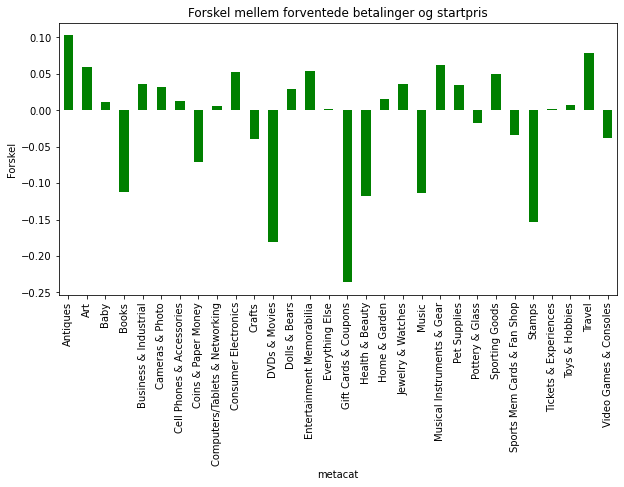

Mean Difference: -0.014343423656817527
Standard Deviation of Differences: 0.08161260707190335


In [25]:
# Beregning af forskelle mellem startprisen og den forventede betaling
diff = d['expected_payment'] - d['price2start']

# Lav et plot til at vise forskellene
plt.figure(figsize=(10,5))
diff.plot(kind='bar', color='green')
plt.ylabel('Forskel')
plt.title('Forskel mellem forventede betalinger og startpris')
plt.show()

# Udskriv gennemsnittet og standardafvigelsen af forskellene
mean_diff = diff.mean()
std_diff = diff.std()
print(f"Mean Difference: {mean_diff}")
print(f"Standard Deviation of Differences: {std_diff}")


# 3.A.3

In [26]:
# Beregn Q-funktionen
def Q(x, df):
    Q_value = np.mean(((x * df['view_item_count'] - 1) / (x * df['view_item_count'] + 1) - df['price2start']) **2)
    return Q_value

# Minimer Q-funktionen
result = minimize(Q, x0 = 0, args=(d), bounds=[(0, 1)])

# Udskriv resultaterne
x_hat = result.x[0]
Q_x_hat = result.fun

# Print resultaterne
print(f'Best estimate x_hat: {x_hat}')
print(f'Corresponding Q(x_hat): {Q_x_hat}')

Best estimate x_hat: 0.23186218307746442
Corresponding Q(x_hat): 0.005594234234550496


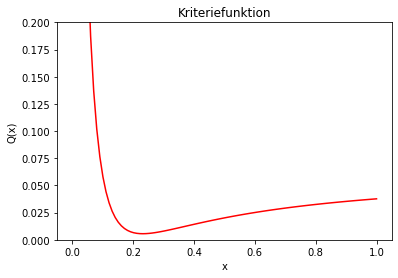

In [27]:
# Plot Q(x)
x_values = np.linspace(0, 1, num=100)
Q_values = [Q(x, d) for x in x_values]

plt.plot(x_values, Q_values, color='red')
plt.xlabel('x')
plt.ylabel('Q(x)')
plt.title('Kriteriefunktion')
plt.ylim(0, 0.2)
plt.show()

# 3.A.4

/var/folders/tr/3b4rdj2n5k17b_lm80t4gkg80000gn/T/ipykernel_6219/2614397041.py:26: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.hist(dat.loc[I, 'price2start'], bins=20, label=cat, alpha=0.6, density=True, edgecolor='white', Color='red')


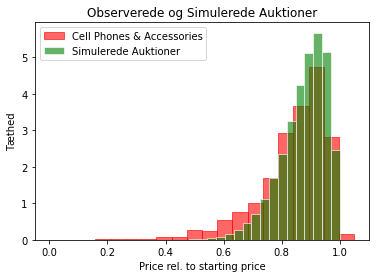

In [28]:
category_data = dat[dat['metacat'] == 'Cell Phones & Accessories']

#Antal simulationer
num_simulations = 100000

nbar_c = 64.3

p_simulations = []

# SPSB
for r in range(num_simulations):
    num_bidders = int(round(x_hat * nbar_c))
    bids = np.random.uniform(low=0, high=1, size=num_bidders)
    highest_bid = max(bids)
    second_highest_bid = sorted(bids)[-2]
    payment = second_highest_bid
    p_simulations.append(payment)

p_simulations = np.array(p_simulations)

#Plot
cats = ['Cell Phones & Accessories']
fig, ax = plt.subplots()
for cat in cats:
    I = (dat['price2start'] < 1.05) & (dat.metacat == cat)
    ax.hist(dat.loc[I, 'price2start'], bins=20, label=cat, alpha=0.6, density=True, edgecolor='white', Color='red')

ax.hist(p_simulations, bins=20, alpha=0.6, density=True, edgecolor='white', label='Simulerede Auktioner', color='green')

ax.legend(loc='best')
ax.set_xlabel(price_labs['price2start'])
ax.set_ylabel('Tæthed')
ax.set_title('Observerede og Simulerede Auktioner')

plt.show()

# 3.A.5

In [29]:
print(dat['photo_count'].mean ())

3.0157931715893724


In [30]:
import scipy.stats as stats

# Opdel data i to grupper baseret på antal fotos
low_photo_count = dat[dat['photo_count'] < 3]['price2start']
high_photo_count = dat[dat['photo_count'] >= 3]['price2start']

# Udfør uafhængig t-test
t_statistic, p_value = stats.ttest_ind(low_photo_count, high_photo_count)

# Udskriv resultaterne
print(f'T-statistik: {t_statistic}')
print(f'P-værdi: {p_value}')

T-statistik: -29.274272905705033
P-værdi: 2.2571205199645786e-188
